# Workflow


The overall workflow is as such:

<ol>
    <li>EDA and imputation process - check missing values, unique values etc and imputation. Query comes from SQL, only SG properties</li>
   <li>Feature selection process - recursively eliminate with VIF. See if any features need to be dropped</li>
   
   <li>Determine suitability for methods. Train an OLS model, check the residuals/fitted values of the beta matrix. Assumptions (Normality of residuals, autocorrelation of residuals, homoskedasticity of residuals). If 0 or 1 assumptions met, reject and use ensemble If 2 or more assumptions met, use OLS.</li>
    <li>Test models</li>
    <li> Convert notebook to proper directory structure </li>
</ol>


# Setup

In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import os
from datetime import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from patsy import dmatrices

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad, het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings('ignore')

# EDA

## Data quantity

* Use SQL. No need

In [2]:
propertyname = 'condo'
dw_ds_estate_id = '4e849dd8d1694b564e369d14e498b880'
filename = f"'{dw_ds_estate_id}'.csv"

df = pd.read_csv(fr"C:\Users\Ryan\Desktop\python\4-REA-Intern\regression2\input\{propertyname}\{filename}")

print("The raw dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))
df.describe()

The raw dataset has 1072 rows and 16 columns


Unnamed: 0  transaction_month_index  transaction_year  \
count  1072.000000              1072.000000       1072.000000   
mean    535.500000            201619.531716       2016.147388   
std     309.604048                53.021682          0.528119   
min       0.000000            201603.000000       2016.000000   
25%     267.750000            201603.000000       2016.000000   
50%     535.500000            201603.000000       2016.000000   
75%     803.250000            201608.000000       2016.000000   
max    1071.000000            202103.000000       2021.000000   

       transaction_month  address_num  address_stack  address_floor  \
count        1072.000000  1072.000000    1072.000000    1072.000000   
mean            4.792910   359.505597      19.513060       8.189366   
std             2.633907     5.148946      10.356837       4.432138   
min             1.000000   351.000000       1.000000       1.000000   
25%             3.000000   355.000000      11.000000       4.000000   
50%             3.000000   359.000000      20.000000       8.000000   
75%             7.000000   365.000000      29.000000      12.000000   
max            12.000000   367.000000      36.000000      17.000000   

       floor_area_sqft  num_of_bedrooms  transaction_amount  
count      1072.000000      1072.000000        1.072000e+03  
mean       1091.392254         2.909515        8.259851e+05  
std          91.705433         0.623402        8.476184e+04  
min         957.907000         2.000000        6.476536e+05  
25%        1086.899015         3.000000        7.581629e+05  
50%        1097.826000         3.000000        8.295898e+05  
75%        1129.895020         3.000000        8.677170e+05  
max        1248.883965         4.000000        1.054913e+06

In [3]:
df.address_num

0       359
1       353
2       353
3       353
4       353
       ... 
1067    365
1068    357
1069    357
1070    353
1071    353
Name: address_num, Length: 1072, dtype: int64

In [4]:
df.head(5)

Unnamed: 0                   dw_ds_estate_id project_name  \
0           0  4e849dd8d1694b564e369d14e498b880   wandervale   
1           1  4e849dd8d1694b564e369d14e498b880   wandervale   
2           2  4e849dd8d1694b564e369d14e498b880   wandervale   
3           3  4e849dd8d1694b564e369d14e498b880   wandervale   
4           4  4e849dd8d1694b564e369d14e498b880   wandervale   

                  dw_transaction_id transaction_date transaction_sub_type  \
0  db5daee2063075fa14f78580c5e7d8a8       2016-03-03              unknown   
1  a0b2273c0248df4bec5912d473ea8cf8       2016-03-04              unknown   
2  6366f97dea417950234267d9c1f31d75       2016-03-04              unknown   
3  322a9249945c5234c703685fa62a2d51       2016-03-04              unknown   
4  304111761ff40af4552fb7d07b7fb805       2016-03-04              unknown   

   transaction_month_index  transaction_year  transaction_month    unit  \
0                   201603              2016                  3  #05-19   
1                   201603              2016                  3  #09-06   
2                   201603              2016                  3  #13-07   
3                   201603              2016                  3  #05-06   
4                   201603              2016                  3  #12-06   

   address_num  address_stack  address_floor  floor_area_sqft  \
0          359             19              5       957.911000   
1          353              6              9      1086.899015   
2          353              7             13      1086.899015   
3          353              6              5      1086.899015   
4          353              6             12      1086.899015   

   num_of_bedrooms  transaction_amount  
0              2.0       746756.450057  
1              3.0       851722.216129  
2              3.0       855720.911980  
3              3.0       836727.106690  
4              3.0       863718.303680

## Univariate distribution

* Not that important, variables do not need to be Gaussian. Only residuals for OLS. However, just to try. Let's take a look a the histograms of the variables!

Remarks:

1. Transaction amount follows Weibull/Exponential distribution. No idea why. Quick ramp up to the modal value and then long tail of extreme values.
2. Most variables exhibit the same pattern of having extreme modality around several values (commoners) and outliers (for rich buyers).

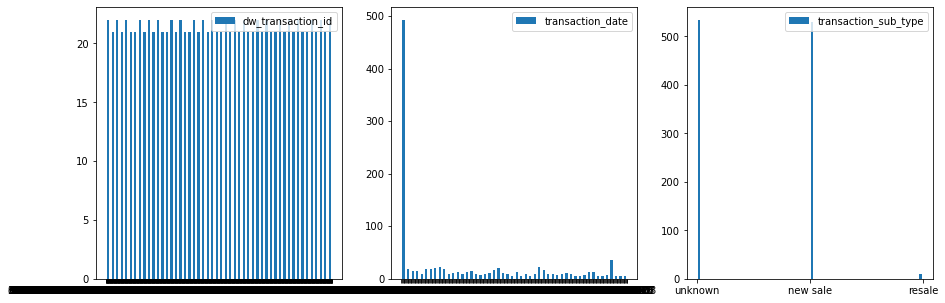

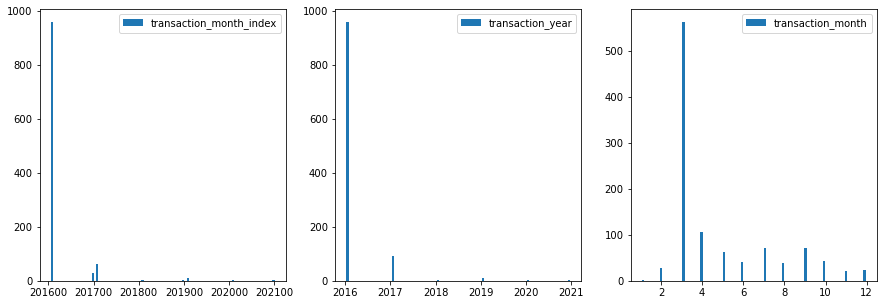

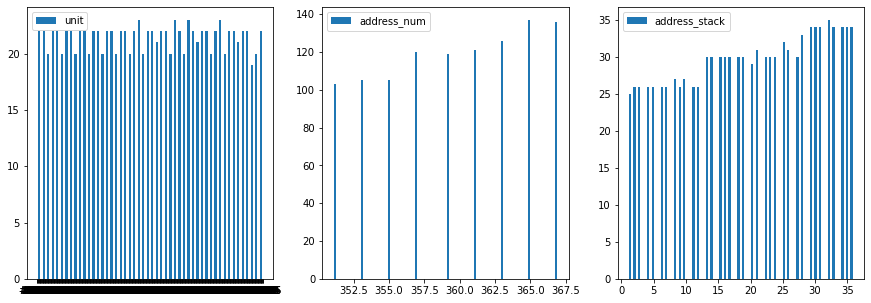

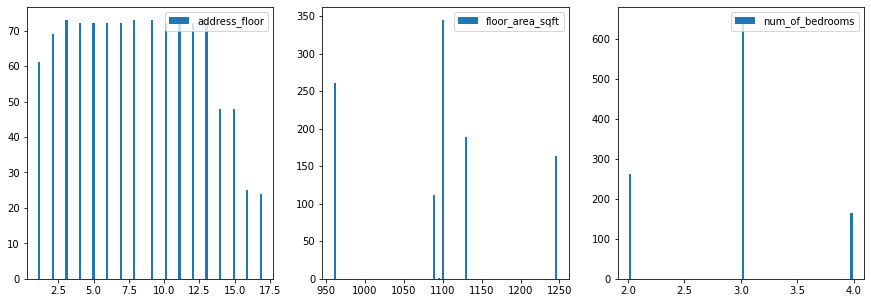

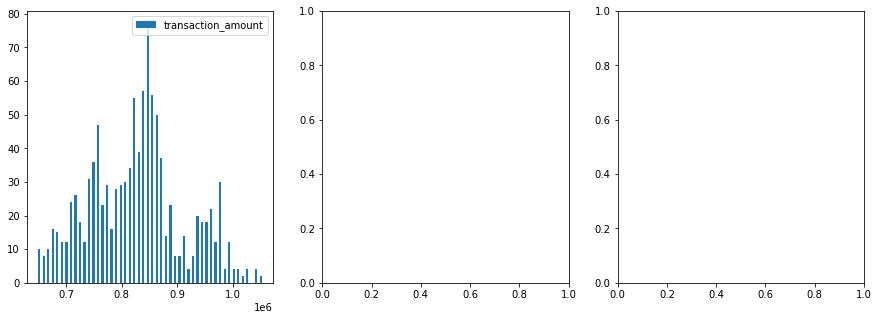

In [5]:
features = df.columns[3:]


for i in range(len(features)):
    if i % 3 == 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        ax1.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax1.legend(loc = "best")
    elif i % 3 == 1:
        ax2.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax2.legend(loc = "best")
    else:
        ax3.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax3.legend(loc = "best")
        
plt.show()

## Multicollinearity check

* We want to check for multicollinearity before we check for OLS. So we use either VIF to recursively eliminate features, or plot a correlation matrix to get some intuition. VIF is defined as $$var(\beta_j)\propto \frac{1}{1 - R^2_j}$$

* If VIF of $X_j$ is 3, then $R^2_j $ is 0.67, if 6, then 0.83.
* Iteratively remove features until no feature has a VIF higher than threshold. However, don't see the point here so never mind.

In [6]:

y, X = dmatrices('transaction_amount ~ transaction_year + transaction_month + address_num + address_stack + address_floor + floor_area_sqft + num_of_bedrooms', 
                 data=df, return_type='dataframe')
X.columns = X.columns.str.replace("[T.&C(&)&\[&\]]","")

In [7]:
X.num_of_bedrooms = X.num_of_bedrooms.astype(int)
X

Intercept  transaction_year  transaction_month  address_num  \
0           1.0            2016.0                3.0        359.0   
1           1.0            2016.0                3.0        353.0   
2           1.0            2016.0                3.0        353.0   
3           1.0            2016.0                3.0        353.0   
4           1.0            2016.0                3.0        353.0   
...         ...               ...                ...          ...   
1067        1.0            2020.0                8.0        365.0   
1068        1.0            2020.0               10.0        357.0   
1069        1.0            2020.0               10.0        357.0   
1070        1.0            2021.0                3.0        353.0   
1071        1.0            2021.0                3.0        353.0   

      address_stack  address_floor  floor_area_sqft  num_of_bedrooms  
0              19.0            5.0       957.911000                2  
1               6.0            9.0      1086.899015                3  
2               7.0           13.0      1086.899015                3  
3               6.0            5.0      1086.899015                3  
4               6.0           12.0      1086.899015                3  
...             ...            ...              ...              ...  
1067           32.0            2.0      1097.826000                3  
1068           14.0           11.0      1086.899015                3  
1069           14.0           11.0      1087.063000                3  
1070            8.0            9.0      1097.897993                3  
1071            8.0            9.0      1097.826000                3  

[1072 rows x 8 columns]

In [8]:
#vif function
def compute_vif(X):
    return pd.Series([variance_inflation_factor(np.array(X),i) 
                     for i in range(X.shape[1])],
                    index = X.columns)


def vif_threshold_check(vif, threshold):
    no_const = vif[1:]
    if len(no_const[no_const > threshold]) > 0:
        return True
    else:
        return False
    
# Eliminate most collinear feature until all VIF fall below a threshold
threshold = 6
vif = compute_vif(X)
print(vif)

'''
while vif_threshold_check(vif, threshold):
    max_vif = vif[1:].max()
    drop_col = vif[1:].idxmax()
    X_with_const.drop(drop_col, axis=1, inplace=True)
    print("Feature {} has been dropped with VIF = {}".format(
        drop_col, max_vif))
    vif = compute_vif(X_with_const)

print("\n{} features eliminated out of {} original features".format(
    len(X.columns) - len(X_with_const.columns) + 1, len(X.columns)))
'''

Intercept            1.537013e+07
transaction_year     1.012686e+00
transaction_month    1.089081e+00
address_num          9.034329e+01
address_stack        8.932051e+01
address_floor        1.058588e+00
floor_area_sqft      6.480562e+01
num_of_bedrooms      6.949017e+01
dtype: float64


'\nwhile vif_threshold_check(vif, threshold):\n    max_vif = vif[1:].max()\n    drop_col = vif[1:].idxmax()\n    X_with_const.drop(drop_col, axis=1, inplace=True)\n    print("Feature {} has been dropped with VIF = {}".format(\n        drop_col, max_vif))\n    vif = compute_vif(X_with_const)\n\nprint("\n{} features eliminated out of {} original features".format(\n    len(X.columns) - len(X_with_const.columns) + 1, len(X.columns)))\n'

# Determine suitability for methods

## Testing OLS assumptions 

* Fit and predict. Get a function to output an array of `residuals`.
* Test normality of residuals. Use Anderson-Darling test, another variant of the Komolgorov-Smirnov test.
* Test for autocorrelation of residuals. Use Durbin Watson.
* Test for heteroskedasticity of residuals. Use the White. White test doesn't work on some, use the Breusch-Pagan instead. Seems like due to some rank of matrix issue.


In [9]:
mod = sm.OLS(y, X)    
res = mod.fit()       
print(res.summary()) 

                            OLS Regression Results                            
Dep. Variable:     transaction_amount   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     990.8
Date:                Wed, 23 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:55:05   Log-Likelihood:                -12604.
No. Observations:                1072   AIC:                         2.522e+04
Df Residuals:                    1064   BIC:                         2.526e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.875e+07   3.71e+0

In [10]:
diagnostics = res.diagn
diagnostics


{'jb': 350.92575721983786,
 'jbpv': 6.272490913438232e-77,
 'skew': 0.31466669000956893,
 'kurtosis': 5.7313890788796265,
 'omni': 90.75294535504268,
 'omnipv': 1.964483149265481e-20,
 'condno': 9099847.879414313,
 'mineigval': 6.97456454121103e-05}

* Anderson Darling Test for normality. rejection region is <0.05 of $H_0$ that the residuals are normally distributed.

2.7037836226370874e-27


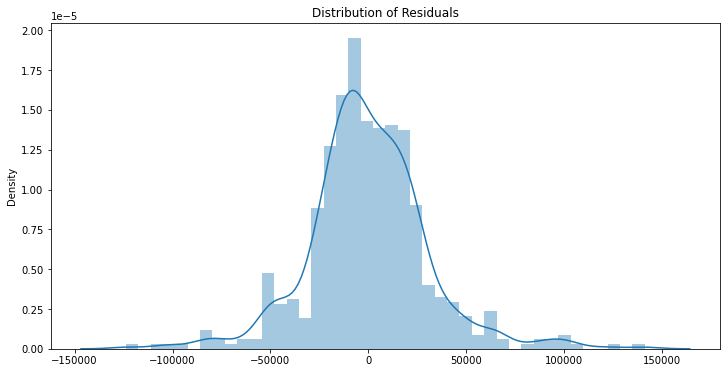

In [11]:
residuals = res.resid
ad_pval = normal_ad(residuals)[1]
print(ad_pval)

plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(residuals)
plt.show()

In [12]:
dw = durbin_watson(residuals)
print(dw)
white_pval = het_breuschpagan(residuals,X)[1]
print(white_pval)

0.8104558746199588
1.827329082507081e-125


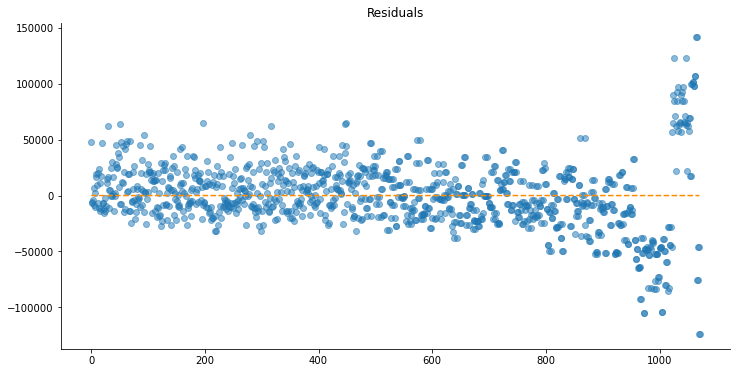

In [13]:
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=residuals.index, y=residuals, alpha=0.5)
plt.plot(np.repeat(0, residuals.index.max()), color='darkorange', linestyle='--')
ax.spines['right'].set_visible(False)  # Removing the right spine
ax.spines['top'].set_visible(False)  # Removing the top spine
plt.title('Residuals')
plt.show()  

In [14]:
res.params

Intercept           -3.875042e+07
transaction_year     1.476521e+04
transaction_month    1.788576e+03
address_num          2.682039e+04
address_stack       -1.487094e+04
address_floor        4.562475e+03
floor_area_sqft      1.298851e+02
num_of_bedrooms      9.210352e+04
dtype: float64

Anyway, the smaller the sample size the better the fit for OLS. Yet there are some problems with OLS (see HDB notebook), so I decided to use another method. See how with large sample size assumptions are violated.

# Train test split

# Model training

In [15]:
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

#variables
y = y
x = X

#train test split
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size =0.2)
#folds
kf5 = KFold(n_splits=5,random_state=0)
#loss
mse = "neg_mean_squared_error"
mae = "neg_mean_absolute_error"
#parameter grids: 27 and 9 combinations respectively
rf_params = {"max_depth": [2,7,10,50,"None"],
              "min_samples_leaf": [1,10,20,30],
              'max_features': [2, 3, 5, "auto"]}
xgb_params = {"n_estimators": [100,500,1000],
            "max_depth":[6],
            "learning_rate":[0.25,0.05,0.005]}
ridge_params = {'alpha':[0.01, 0.1,1, 10, 100, 1000]}
#models
rf = RandomForestRegressor(random_state=0)
xgb = XGBRegressor(random_state=0)
ridge = Ridge(random_state=0)


#cross-validation object



#functions, no classes here.
def grid_object(x,y, estimator, params, scoring, cv):
    """returns a fitted object"""
    grid = GridSearchCV(estimator = estimator, param_grid = params, scoring = scoring, cv = cv,
                           n_jobs = -1, return_train_score = True)
    grid.fit(x,y)
    return grid

def report_GridSearchCV_results(grid,modelname):
    print(f"CV Results for {modelname}: \n")
    print("- Best combination of hyperparams:\n", grid.best_params_, "\n")
    print("- Best mean_test_score:\n", grid.best_score_, "\n")
    print(f"-Best mean_test_score square root: {math.sqrt(abs(grid.best_score_))} \n\n")
    
    scores = []
    for i in range(grid.n_splits_):
        scores.append(grid.cv_results_['split{}_test_score'.format(i)][grid.best_index_])
    print("- Score by fold for best estimator:\n", scores, "\n")
    
    # View top 10 hyperparams combinations by mean_test_score (averaged CV score over all folds)
    print("- Top 10 hyperparams combinations by mean_test_score:")
    print(pd.DataFrame(grid.cv_results_)[["rank_test_score", "mean_test_score","mean_train_score"] 
                                            + ["param_" + param for param in grid.param_grid]]
              .sort_values(by = "mean_test_score", ascending = False)
              .set_index("rank_test_score").head(10))
    
    return grid.best_estimator_

def plot_feature_importance(estimator,x, model_name):
    plt.figure(figsize = (10, 10))
    features, importances = x.columns, estimator.feature_importances_
    sns.barplot(importances,features, orient="h").set(title="{} || Avg. feature importance for best hyperparams".format(model_name))
    plt.show()    
    return None

#train models

rf = grid_object(x_train, np.array(y_train).ravel(),rf,rf_params,mse,kf5)
best_rf = report_GridSearchCV_results(rf,"rf")
plot_feature_importance(best_rf,x_train,"rf")

xgb = grid_object(x_train, np.array(y_train).ravel(),xgb,xgb_params,mse,kf5)
best_xgb = report_GridSearchCV_results(xgb,"xgb")
plot_feature_importance(best_xgb,x_train,"xgb")


CV Results for rf: 

- Best combination of hyperparams:
 {'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1} 

- Best mean_test_score:
 -380312482.8729313 

-Best mean_test_score square root: 19501.60205913687 


- Score by fold for best estimator:
 [-246756941.00782686, -209079766.0949399, -247708524.69612005, -183960690.99115723, -1014056491.5746123] 

- Top 10 hyperparams combinations by mean_test_score:
                 mean_test_score  mean_train_score param_max_depth  \
rank_test_score                                                      
1                  -3.803125e+08     -4.438541e+07              50   
2                  -3.958832e+08     -7.404728e+07              10   
3                  -4.002577e+08     -5.061140e+07              50   
4                  -4.006852e+08     -4.626145e+07              50   
5                  -4.052933e+08     -4.387792e+07              50   
6                  -4.142308e+08     -7.784445e+07              10   
7               

CV Results for xgb: 

- Best combination of hyperparams:
 {'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 1000} 

- Best mean_test_score:
 -203852289.73246494 

-Best mean_test_score square root: 14277.685027078618 


- Score by fold for best estimator:
 [-77737625.80083975, -111635160.53892775, -270118900.45964545, -63708785.32366513, -496060976.53924656] 

- Top 10 hyperparams combinations by mean_test_score:
                 mean_test_score  mean_train_score param_n_estimators  \
rank_test_score                                                         
1                  -2.038523e+08     -9.385247e+00               1000   
2                  -2.038531e+08     -4.552295e+03                500   
3                  -2.084595e+08     -5.696952e+06                100   
4                  -2.121016e+08     -9.859169e+05               1000   
5                  -2.165800e+08     -6.881351e+06                500   
6                  -4.088803e+08     -1.507895e+08                

# Partial Dependence Plots/SHAP variability

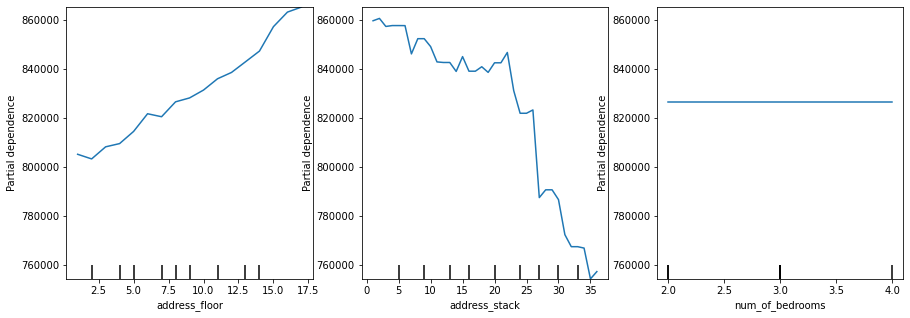

In [16]:
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence

best_xgb.dummy_='dummy'

condo_feature_str = ["address_floor","address_stack","num_of_bedrooms"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 5))

plot_partial_dependence(best_rf,X,features = condo_feature_str, ax=[ax1,ax2,ax3])
plot_partial_dependence(best_xgb,x_train,features = condo_feature_str,ax=[ax4,ax5,ax6])

* First row is RF PDP.
* Second row is XGB PDP.

Notice how XGB PDP for `num_of_bedrooms` is a straight line and it's feature importance in XGB above is also 0. This is some bug, so we end up sticking with RF.

In [17]:
from sklearn.metrics import mean_squared_error


best_rf_test_mse = mean_squared_error(y_test, best_rf.predict(x_test))
best_xgb_test_mse = mean_squared_error(y_test, best_xgb.predict(x_test))
best_OLS_test_mse = mean_squared_error(y_test,res.predict(x_test))
print(math.sqrt(best_rf_test_mse))
print(math.sqrt(best_xgb_test_mse))
print(math.sqrt(best_OLS_test_mse))

11953.80467841625
7972.239415344816
30080.72292285801


Note how with this large sample size of ~1000, OLS performs the worst. Compare this to the HDB notebook.

In [18]:
predictions, values = partial_dependence(best_rf,x,features = "address_floor")
pdp_coefficients = pd.DataFrame({"feature":np.array(values).flatten(),"value":np.array(predictions).flatten()})

pdp_coefficients.value = ((pdp_coefficients.value/pdp_coefficients.value[0])-1)*100
pdp_coefficients["project_name"] = dw_ds_estate_id
pdp_coefficients

feature     value                      project_name
0       1.0  0.000000  4e849dd8d1694b564e369d14e498b880
1       2.0 -0.189908  4e849dd8d1694b564e369d14e498b880
2       3.0 -0.162033  4e849dd8d1694b564e369d14e498b880
3       4.0 -0.015070  4e849dd8d1694b564e369d14e498b880
4       5.0  1.227313  4e849dd8d1694b564e369d14e498b880
5       6.0  2.681460  4e849dd8d1694b564e369d14e498b880
6       7.0  2.917275  4e849dd8d1694b564e369d14e498b880
7       8.0  3.431027  4e849dd8d1694b564e369d14e498b880
8       9.0  3.870798  4e849dd8d1694b564e369d14e498b880
9      10.0  4.096101  4e849dd8d1694b564e369d14e498b880
10     11.0  4.646820  4e849dd8d1694b564e369d14e498b880
11     12.0  5.023649  4e849dd8d1694b564e369d14e498b880
12     13.0  5.478930  4e849dd8d1694b564e369d14e498b880
13     14.0  5.839035  4e849dd8d1694b564e369d14e498b880
14     15.0  6.970001  4e849dd8d1694b564e369d14e498b880
15     16.0  7.315622  4e849dd8d1694b564e369d14e498b880
16     17.0  7.788056  4e849dd8d1694b564e369d14e498b880

In [48]:
emptylist = []

for i in range(4):
    emptylist.append(pdp_coefficients)

In [49]:

df = pd.concat(emptylist).reset_index()

In [50]:
df.head(50)

index  feature     value                      project_name
0       0      1.0  0.000000  4e849dd8d1694b564e369d14e498b880
1       1      2.0 -0.189908  4e849dd8d1694b564e369d14e498b880
2       2      3.0 -0.162033  4e849dd8d1694b564e369d14e498b880
3       3      4.0 -0.015070  4e849dd8d1694b564e369d14e498b880
4       4      5.0  1.227313  4e849dd8d1694b564e369d14e498b880
5       5      6.0  2.681460  4e849dd8d1694b564e369d14e498b880
6       6      7.0  2.917275  4e849dd8d1694b564e369d14e498b880
7       7      8.0  3.431027  4e849dd8d1694b564e369d14e498b880
8       8      9.0  3.870798  4e849dd8d1694b564e369d14e498b880
9       9     10.0  4.096101  4e849dd8d1694b564e369d14e498b880
10     10     11.0  4.646820  4e849dd8d1694b564e369d14e498b880
11     11     12.0  5.023649  4e849dd8d1694b564e369d14e498b880
12     12     13.0  5.478930  4e849dd8d1694b564e369d14e498b880
13     13     14.0  5.839035  4e849dd8d1694b564e369d14e498b880
14     14     15.0  6.970001  4e849dd8d1694b564e369d14e498b880
15     15     16.0  7.315622  4e849dd8d1694b564e369d14e498b880
16     16     17.0  7.788056  4e849dd8d1694b564e369d14e498b880
17      0      1.0  0.000000  4e849dd8d1694b564e369d14e498b880
18      1      2.0 -0.189908  4e849dd8d1694b564e369d14e498b880
19      2      3.0 -0.162033  4e849dd8d1694b564e369d14e498b880
20      3      4.0 -0.015070  4e849dd8d1694b564e369d14e498b880
21      4      5.0  1.227313  4e849dd8d1694b564e369d14e498b880
22      5      6.0  2.681460  4e849dd8d1694b564e369d14e498b880
23      6      7.0  2.917275  4e849dd8d1694b564e369d14e498b880
24      7      8.0  3.431027  4e849dd8d1694b564e369d14e498b880
25      8      9.0  3.870798  4e849dd8d1694b564e369d14e498b880
26      9     10.0  4.096101  4e849dd8d1694b564e369d14e498b880
27     10     11.0  4.646820  4e849dd8d1694b564e369d14e498b880
28     11     12.0  5.023649  4e849dd8d1694b564e369d14e498b880
29     12     13.0  5.478930  4e849dd8d1694b564e369d14e498b880
30     13     14.0  5.839035  4e849dd8d1694b564e369d14e498b880
31     14     15.0  6.970001  4e849dd8d1694b564e369d14e498b880
32     15     16.0  7.315622  4e849dd8d1694b564e369d14e498b880
33     16     17.0  7.788056  4e849dd8d1694b564e369d14e498b880
34      0      1.0  0.000000  4e849dd8d1694b564e369d14e498b880
35      1      2.0 -0.189908  4e849dd8d1694b564e369d14e498b880
36      2      3.0 -0.162033  4e849dd8d1694b564e369d14e498b880
37      3      4.0 -0.015070  4e849dd8d1694b564e369d14e498b880
38      4      5.0  1.227313  4e849dd8d1694b564e369d14e498b880
39      5      6.0  2.681460  4e849dd8d1694b564e369d14e498b880
40      6      7.0  2.917275  4e849dd8d1694b564e369d14e498b880
41      7      8.0  3.431027  4e849dd8d1694b564e369d14e498b880
42      8      9.0  3.870798  4e849dd8d1694b564e369d14e498b880
43      9     10.0  4.096101  4e849dd8d1694b564e369d14e498b880
44     10     11.0  4.646820  4e849dd8d1694b564e369d14e498b880
45     11     12.0  5.023649  4e849dd8d1694b564e369d14e498b880
46     12     13.0  5.478930  4e849dd8d1694b564e369d14e498b880
47     13     14.0  5.839035  4e849dd8d1694b564e369d14e498b880
48     14     15.0  6.970001  4e849dd8d1694b564e369d14e498b880
49     15     16.0  7.315622  4e849dd8d1694b564e369d14e498b880